In [34]:
%pylab inline
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import itertools
import scipy

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
credit_history = pd.read_csv('credit_card_default_analysis.csv',',')

In [3]:
credit_history.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
credit_history.shape

(30000, 25)

# 1.  Размер кредитного лимита

In [5]:
credit_history.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

### Сравним кредитные лимиты для 2-х категорий людей:

In [14]:
limitBal0 = credit_history[credit_history['default']  == 0].LIMIT_BAL
limitBal1 = credit_history[credit_history['default']  == 1].LIMIT_BAL

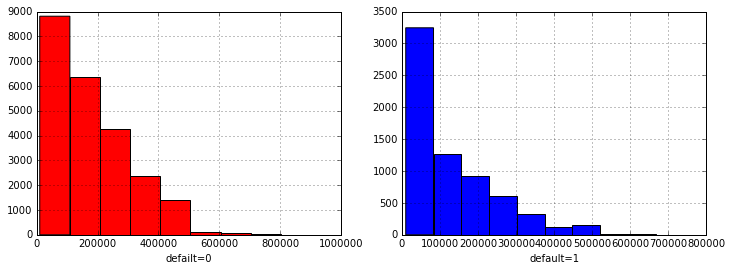

In [15]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(limitBal0, color = 'r')
pylab.xlabel('defailt=0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(limitBal1, color = 'b')
pylab.xlabel('default=1')

pylab.show()

default - индикатор невозврата денежных средств

## Проверим гипотезу о  равенстве медианных значений кредитного лимита с помощью бутстрепа

### Bootstrap

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [9]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

### Интервальная оценка медианы

In [17]:
np.random.seed(0)

limitBal0_median_scores = map(np.median, get_bootstrap_samples(limitBal0.values,1000))
limitBal1_median_scores = map(np.median, get_bootstrap_samples(limitBal1.values, 1000))

print "95% confidence interval for the credit limit without default:",  stat_intervals(limitBal0_median_scores, 0.05)
print "95% confidence interval for the credit limit with default:",  stat_intervals(limitBal1_median_scores, 0.05)

ERROR: Line magic function `%limitBal0` not found.
ERROR: Line magic function `%limitBal1` not found.


95% confidence interval for the credit limit without default: [ 150000.  150000.]
95% confidence interval for the credit limit with default: [ 80000.  90000.]


## Медианные значения не равны!

### Точечная оценка разности медиан

In [18]:
print "difference between medians:", np.median(limitBal0) - np.median(limitBal1)

difference between medians: 60000.0


### Интервальная оценка разности медиан

In [19]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(limitBal1_median_scores, limitBal0_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [ 60000.  70000.]


In [20]:
stats.mannwhitneyu(limitBal0, limitBal1)

MannwhitneyuResult(statistic=95786286.5, pvalue=nan)

## Проверим гипотезу о равенстве распределений с помощью перестановочного критерия

### Перестановочный критерий

$H_0: F_{X_1}(x) = F_{X_2}(x)$

$H_1: F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [21]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [22]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [23]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

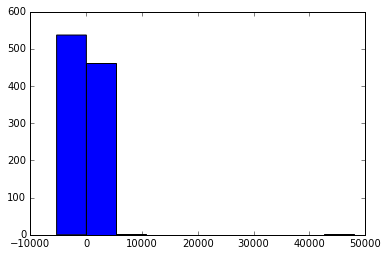

In [24]:
#limitBal0 = credit_history[credit_history['default']  == 0].LIMIT_BAL
#limitBal1 = credit_history[credit_history['default']  == 1].LIMIT_BAL
pylab.hist(permutation_zero_dist_ind(limitBal0, limitBal1, max_combinations = 1000))
pylab.show()

In [25]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [ ]:
print "p-value: %f" % permutation_test(limitBal0, limitBal1, max_permutations = 10000)

p-value: 0.000100


## Гипотеза о равенстве средних отвергается против 2-х сторонней альтернативы на уровне 0.05!

## Разница в размерах кредитов практически значима!

# 2. Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.

In [45]:
sex0 = credit_history[credit_history['default']  == 0].SEX
sex1 = credit_history[credit_history['default']  == 1].SEX

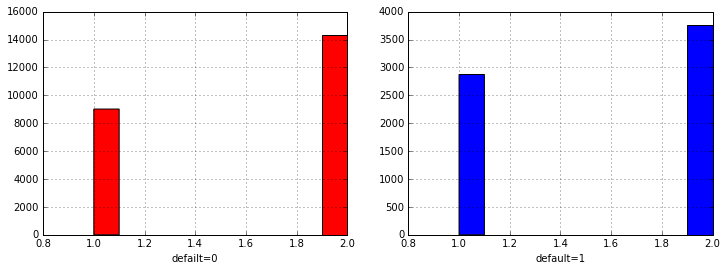

In [29]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(sex0, color = 'r')
pylab.xlabel('defailt=0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(sex1, color = 'b')
pylab.xlabel('default=1')

pylab.show()

In [46]:
sex0 = sex0-1
sex1 = sex1-1

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

$$Z-статистика: Z({X_1, X_2}) =  \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}$$
$$P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}} $$

In [48]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [49]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [50]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [51]:
print "95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(sex0, sex1)

95% confidence interval for a difference between proportions: [0.033635, 0.060548]


гипотеза о том, что гендерный состав группы людей вернувших и не вернувших кредит не отличается отвергается, поскольку доверительный интервал не содержит 0

In [52]:
print "p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(sex0, sex1))

p-value: 0.000000


Z-критерий также отвергает нулевую гипотезу

### Однако доля женщин среди вернувших кредит выше только на примерно 3-6%, так что это может не играть существенной роли

# 3. Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.

In [81]:
obs = []
for i in range(7):
    tmp = credit_history[credit_history['EDUCATION'] == i].default.values
    obsm=sum(tmp)
    obsp=len(tmp) - sum(tmp)
    obs.append([obsp, obsm])
obs = np.array(obs)

In [82]:
obs

array([[   14,     0],
       [ 8549,  2036],
       [10700,  3330],
       [ 3680,  1237],
       [  116,     7],
       [  262,    18],
       [   43,     8]], dtype=int64)

Таблица cверху:
первая колонка  - количество возвратов, 2-ая - дефолтов
Строки: EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

In [83]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(obs)
print p

1.23326262454e-32


## Нулевая гипотеза о том, что образование не играет роли отвергается

### Таблица сопряженности образование на возврат долга,  где значением ячейки разность между наблюдаемым и ожидаемым количеством человек:

In [84]:
obs-expected

array([[   3.0968,   -3.0968],
       [ 305.402 , -305.402 ],
       [-226.564 ,  226.564 ],
       [-149.3596,  149.3596],
       [  20.2076,  -20.2076],
       [  43.936 ,  -43.936 ],
       [   3.2812,   -3.2812]])

### Приведем знаения ячеек к одному масштабу, отнормировав на количество событий в каждой категории: 

In [85]:
diff = obs - expected

In [76]:
diff.shape

(7L, 2L)

In [86]:
scaled_diff=diff
for i in range(7):
    scaled_diff[i,0] = diff[i,0]/sum(obs[i,:])
    scaled_diff[i,1] = diff[i,1]/sum(obs[i,:])
scaled_diff    

array([[ 0.2212    , -0.2212    ],
       [ 0.02885234, -0.02885234],
       [-0.01614854,  0.01614854],
       [-0.03037616,  0.03037616],
       [ 0.16428943, -0.16428943],
       [ 0.15691429, -0.15691429],
       [ 0.06433725, -0.06433725]])

Строки сверху : EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

## Видно что, Выпускники школы наиболее вероятны не вернуть кредит, в то время как доктора самые надежные!

# 4. Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [88]:
obs = []
for i in range(4):
    tmp = credit_history[credit_history['MARRIAGE'] == i].default.values
    obsm=sum(tmp)
    obsp=len(tmp) - sum(tmp)
    obs.append([obsp, obsm])
obs = np.array(obs)

In [89]:
obs

array([[   49,     5],
       [10453,  3206],
       [12623,  3341],
       [  239,    84]], dtype=int64)

Таблица cверху:
первая колонка  - количество возвратов, 2-ая - дефолтов
Строки: MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

In [90]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(obs)
print p

8.82586245758e-08


In [ ]:
Нулевая гипотеза о том, что семейное положение не играет роли отвергается

In [91]:
diff = obs - expected

In [92]:
diff.shape

(4L, 2L)

In [93]:
print diff

[[   6.9448   -6.9448]
 [-184.6292  184.6292]
 [ 190.2368 -190.2368]
 [ -12.5524   12.5524]]


In [94]:
scaled_diff=diff
for i in range(4):
    scaled_diff[i,0] = diff[i,0]/sum(obs[i,:])
    scaled_diff[i,1] = diff[i,1]/sum(obs[i,:])
scaled_diff 

array([[ 0.12860741, -0.12860741],
       [-0.01351704,  0.01351704],
       [ 0.01191661, -0.01191661],
       [-0.03886192,  0.03886192]])

In [ ]:
Видно, что женатых людей больше среди тех, кто не отдал долгоднако разница небольшая, так что вряд ли она практически значима

# 5.  Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы (решение аналогично №1):

## a) о равенстве медианных значений возрастов людей ## 

In [58]:
age0 = credit_history[credit_history['default']  == 0].AGE
age1 = credit_history[credit_history['default']  == 1].AGE

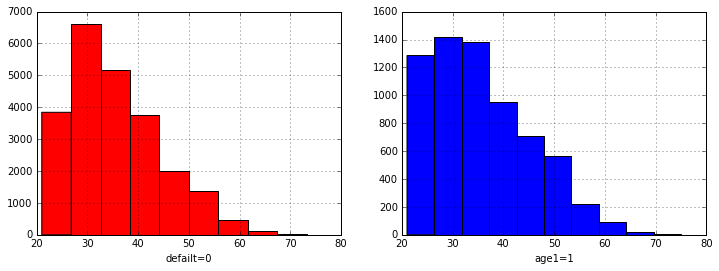

In [59]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(age0, color = 'r')
pylab.xlabel('defailt=0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(limitBal1, color = 'b')
pylab.xlabel('default=1')

pylab.show()

In [ ]:
AGE: возраст в годах

### Интервальная оценка медианы с помощью бутстрепа

In [61]:
np.random.seed(0)

age0_median_scores = map(np.median, get_bootstrap_samples(age0.values,1000))
age1_median_scores = map(np.median, get_bootstrap_samples(age1.values, 1000))

print "95% confidence interval for the credit limit without default:",  stat_intervals(age0_median_scores, 0.05)
print "95% confidence interval for the credit limit with default:",  stat_intervals(age1_median_scores, 0.05)

95% confidence interval for the credit limit without default: [ 34.  34.]
95% confidence interval for the credit limit with default: [ 34.  35.]


### Доверительные интервалы пересекаются, а следовательно гипотеза о равенстве медианных возрастов 2-х групп не отвергается. Разность медиан можно признать практически не значимой

## b) Проверим гипотезу о равенстве распределений с помощью перестановочного критерия

In [62]:
print "p-value: %f" % permutation_test(age0, age1, max_permutations = 10000)

p-value: 0.017700


### Нулевая гипотеза о равенстве средних отвергается против 2-х сторонней альтернативы на уровне 0.05.